# UrbanPy model for Florianópolis
Start date: 2022-12-30

Make sure the necessary packages are installed from the `pipenv` file created for this work.

To do this, go to the local directory for this project, and in your terminal run:

`pipenv install`

Then, activate the environment by running 

`pipenv shell`

**Note**: @robcrystalornelas needed to run `brew install gdal` in terminal and then `pip install urbanpy` in this notebook to get code below to run. Issue submitted about installation difficulties [here](https://github.com/EL-BID/urbanpy/issues/18).

In [30]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)


import sys
sys.path.append('..')

import urbanpy as up
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely
import plotly.express as px 
import osmnx as ox

## Download urban data

We'll begin by downloading data for Florianópolis, Brazil.  Specify the place we'll analyze by name (this is just for displaying on the map we print out below), and then the function ending in _osm gives us the city limits. 

In [31]:
city = 'Florianópolis, Brazil'
flor = up.download.nominatim_osm(city)

Plot the data we downloaded for Florianopolis

Text(0.5, 1.0, 'Florianópolis, Brazil')

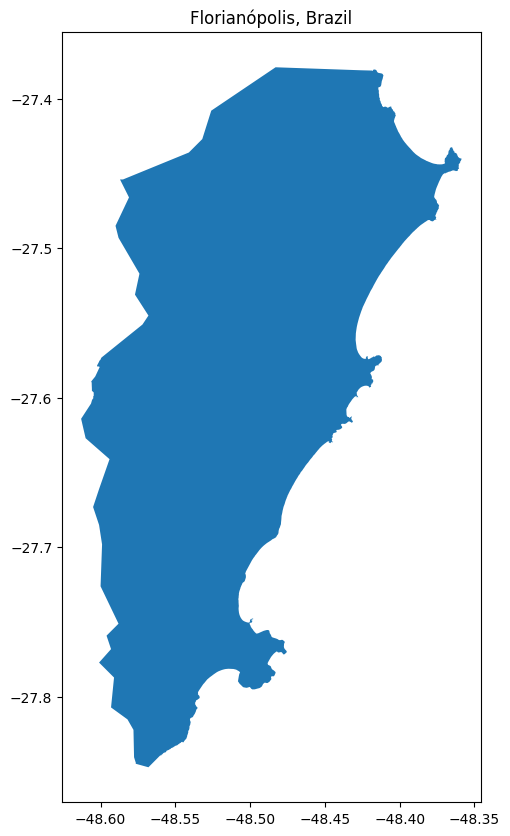

In [32]:
flor.plot()
plt.title(city)

## Divide city into hexagons for spatial analysis

In the function below, the city argument requires a spatial object (for us Florianopolis).
`resolution` argument can be adjusted depending on how many hexagons we want in our grid. 

_Higher numbers means greater resolution and a greater number of cells._

In [33]:
h3_resolution = 8

hex_flor = up.geom.gen_hexagons(h3_resolution, city=flor)

Visualize the city with our hexagons

Text(0.5, 1.0, 'Florianópolis, Brazil. Cells H3 with resolution 8')

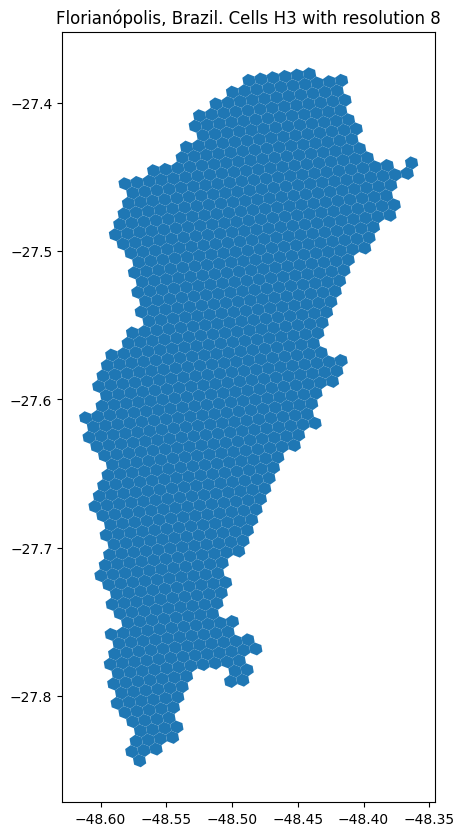

In [34]:
hex_flor.plot()
plt.title(city + ". Cells H3 with resolution " + str(h3_resolution))

Inspect the first few rows of data


In [35]:
hex_flor.head()

,hex,geometry
0,88a91b5747fffff,"POLYGON ((-48.51725 -27.75584, -48.51307 -27.7..."
1,88a91b4097fffff,"POLYGON ((-48.46816 -27.57638, -48.46398 -27.5..."
2,88a91b4451fffff,"POLYGON ((-48.57812 -27.56660, -48.57394 -27.5..."
3,88a91b42b1fffff,"POLYGON ((-48.47286 -27.62394, -48.46868 -27.6..."
4,88a91b5759fffff,"POLYGON ((-48.54492 -27.75845, -48.54074 -27.7..."


And see how many rows we have in the dataset. The number of rows (first number below) tells us how many cells florianopolis was divided into

In [36]:
hex_flor.shape

(977, 2)

## Download population data

You can see the data/metadata in HDX UI [here](https://data.humdata.org/dataset/brazil-high-resolution-population-density-maps-demographic-estimates).

We get the population data at the *country* level from a function in `urbanpy`.  First, list the country, then the type of population:

- `full`: entire population **this argument does not work, needs to be hard coded**
- `children`: children (age 0-5)
- `youth`: youth (15-24)
- `elderly`: Ages 60+

So let's start by getting Brazil population data.  As discussed in this [issue](https://github.com/EL-BID/urbanpy/issues/19), the population data gets moved sometimes so we need to hard code links to the full demographic data.

But if you want segments of the population for all of Brazil, that can be done through built in functions.

Look for brazil's population data here: https://data.humdata.org/dataset/brazil-high-resolution-population-density-maps-demographic-estimates

In [37]:
# pop_brazil = up.download.hdx_fb_population('brazil', 'youth')

The code below takes about 45 seconds to run.

In [38]:
full_pop_brazil_southeast = up.download.hdx_dataset(resource="c17003d1-47f4-4ec5-8229-2f77aeb114be/resource/eb17516f-3c84-4626-95e4-df1f342f3d82/download/population_bra_southeast_2018-10-01.csv.zip")

Take a look at the population data. For Brazil, all these data are from 2019

In [39]:
full_pop_brazil_southeast.head()

,latitude,longitude,population_2015,population_2020
0,-31.311806,-50.980972,1.023954,0.996145
1,-31.278194,-50.942361,1.279943,1.245182
2,-31.277917,-50.942361,1.279943,1.245182
3,-31.277917,-50.942083,1.279943,1.245182
4,-31.277917,-50.941806,1.279943,1.245182


Next, filter for the area of interest. The `filter_population` function works by a bounding box, so not an exact shape of the city of interest


In [40]:
pop_flor = up.geom.filter_population(full_pop_brazil_southeast, flor)

Now visualize the population data. We'll see that the data go beyond the city limits

<AxesSubplot: >

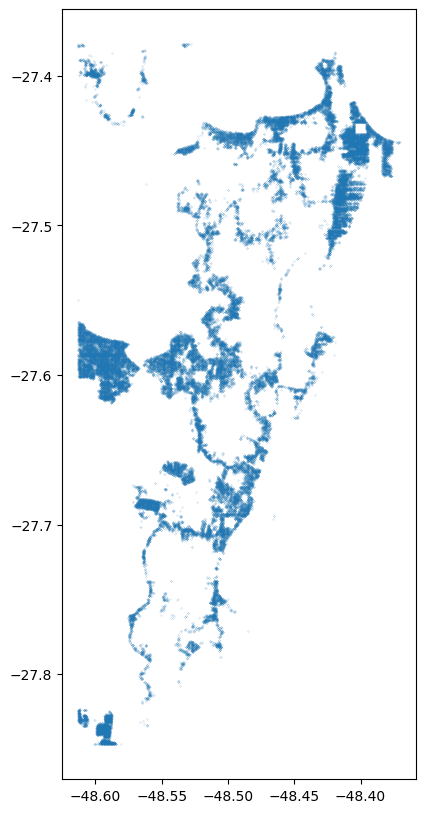

In [41]:
pop_flor.plot(markersize=0.01)

Then, calculate the population per hexagon. 

**Note** be sure to change the field `population_2020` to match the population column in your dataset. There are sometimes multiple population columns downloaded for different census times.

In [42]:
pop_flor.head()

,latitude,longitude,population_2015,population_2020,geometry
889185,-27.846806,-48.600694,0.533490,0.599087,POINT (-48.60069 -27.84681)
889186,-27.846806,-48.600417,0.533490,0.599087,POINT (-48.60042 -27.84681)
889187,-27.846806,-48.600139,0.533490,0.599087,POINT (-48.60014 -27.84681)
889188,-27.846806,-48.599306,0.473721,0.531969,POINT (-48.59931 -27.84681)
889189,-27.846806,-48.597083,0.473721,0.531969,POINT (-48.59708 -27.84681)


In [43]:
hex_flor.head()

,hex,geometry
0,88a91b5747fffff,"POLYGON ((-48.51725 -27.75584, -48.51307 -27.7..."
1,88a91b4097fffff,"POLYGON ((-48.46816 -27.57638, -48.46398 -27.5..."
2,88a91b4451fffff,"POLYGON ((-48.57812 -27.56660, -48.57394 -27.5..."
3,88a91b42b1fffff,"POLYGON ((-48.47286 -27.62394, -48.46868 -27.6..."
4,88a91b5759fffff,"POLYGON ((-48.54492 -27.75845, -48.54074 -27.7..."


In [44]:
hex_flor = up.geom.merge_shape_hex(
    hexs = hex_flor, 
    shape = pop_flor, 
    agg={'population_2020': 'sum'}
)

In [45]:
hex_flor.head()

,hex,geometry,population_2020
0,88a91b5747fffff,"POLYGON ((-48.51725 -27.75584, -48.51307 -27.7...",13.858327
1,88a91b4097fffff,"POLYGON ((-48.46816 -27.57638, -48.46398 -27.5...",NaN
2,88a91b4451fffff,"POLYGON ((-48.57812 -27.56660, -48.57394 -27.5...",NaN
3,88a91b42b1fffff,"POLYGON ((-48.47286 -27.62394, -48.46868 -27.6...",29.624559
4,88a91b5759fffff,"POLYGON ((-48.54492 -27.75845, -48.54074 -27.7...",83.792873


## Visualize data on static map

And then look at these data on a map

Text(0.5, 1.0, 'Florianópolis, Brazil. Population 2020')

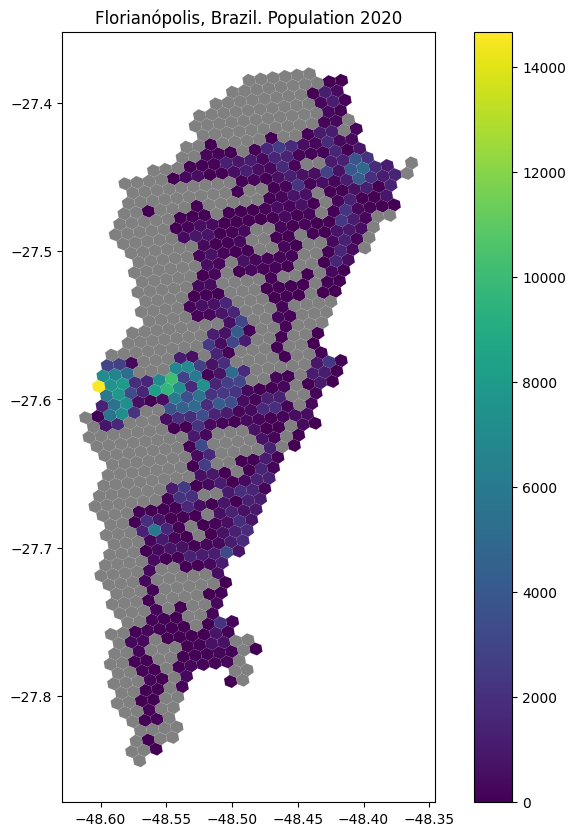

In [46]:
hex_flor.plot('population_2020', legend=True, missing_kwds={'color':'grey'})
plt.title(city + ". Population 2020")

## Visualize data on interactive map

In [47]:
fig = up.plotting.choropleth_map(
    hex_flor, 
    'population_2020', 
    title=city + '. Population - 2020', 
    zoom = 10, 
    color_continuous_scale="Viridis",
    opacity=0.8,
    labels={'population':'Population 2020'}                                 
)

fig.update_layout(
    margin=dict(l=0, r=0, t=30, b=0),
)

fig.show()

## Take another slice of the population. This time focusing on children 0-5

In [48]:
pop_brazil_children = up.download.hdx_fb_population('brazil', 'children')

In [49]:
pop_brazil_children.head()

,latitude,longitude,population
0,-27.012917,-51.737361,0.330375
1,-27.010139,-51.738750,0.330375
2,-27.009583,-51.740417,0.330375
3,-27.010139,-51.741806,0.330375
4,-27.009306,-51.739028,0.330375


In [50]:
pop_brazil_children = up.geom.filter_population(pop_brazil_children, flor)

In [51]:
hex_flor_children = up.geom.merge_shape_hex(hex_flor, pop_brazil_children, agg={'population':'sum'})

Check out results

In [52]:
hex_flor_children.head()

,hex,geometry,population_2020,population
0,88a91b5747fffff,"POLYGON ((-48.51725 -27.75584, -48.51307 -27.7...",13.858327,0.864365
1,88a91b4097fffff,"POLYGON ((-48.46816 -27.57638, -48.46398 -27.5...",NaN,NaN
2,88a91b4451fffff,"POLYGON ((-48.57812 -27.56660, -48.57394 -27.5...",NaN,NaN
3,88a91b42b1fffff,"POLYGON ((-48.47286 -27.62394, -48.46868 -27.6...",29.624559,0.901144
4,88a91b5759fffff,"POLYGON ((-48.54492 -27.75845, -48.54074 -27.7...",83.792873,5.245495


In [53]:
hex_flor_children = hex_flor_children.rename(columns = {'population':'pop_children_flor'})

In [54]:
hex_flor_children.head()

,hex,geometry,population_2020,pop_children_flor
0,88a91b5747fffff,"POLYGON ((-48.51725 -27.75584, -48.51307 -27.7...",13.858327,0.864365
1,88a91b4097fffff,"POLYGON ((-48.46816 -27.57638, -48.46398 -27.5...",NaN,NaN
2,88a91b4451fffff,"POLYGON ((-48.57812 -27.56660, -48.57394 -27.5...",NaN,NaN
3,88a91b42b1fffff,"POLYGON ((-48.47286 -27.62394, -48.46868 -27.6...",29.624559,0.901144
4,88a91b5759fffff,"POLYGON ((-48.54492 -27.75845, -48.54074 -27.7...",83.792873,5.245495


In [55]:
fig = up.plotting.choropleth_map(hex_flor_children, 'pop_children_flor', title=city + '. Estimated population for 0-5 year olds - 2019', 
                                 zoom = 10, color_continuous_scale="Viridis",
                                 opacity=0.8,
                                 labels={'pop_children_flor':'Children age 0-5 in 2019'}
                                 
                                 )

fig.update_layout(
    margin=dict(l=0, r=0, t=30, b=0),
)

fig.show()

## Urban accessibility

First, we have to define the location of interest and get lat/long for those points of interest.
 
We will get these point of interest from the OpenStreetMap database

You need to specify a bounding box which we can get from:

In [59]:
ciudad = 'Florianópolis, Brazil'

ba = up.download.nominatim_osm(ciudad)

We are interested in evaluating accessibility to schools/education infrastructure.

In [60]:
ba.total_bounds

array([-48.613    , -27.847    , -48.3585929, -27.379    ])

In [79]:
es = up.download.overpass_pois(bounds=ba.total_bounds, facilities='education')

[info] Loaded compressed node based graph: 5296926 edges, 14199763 nodes
[info]  running partition: 128 1.2 0.25 10 1000 # max_cell_size balance boundary cuts small_component_size


[info] Found 12205300 SCC (2 large, 12205298 small)
[info] SCC run took: 1.45691s


Keeping the code below in case overpass does not work

In [80]:
import requests

minx, miny, maxx, maxy = ba.total_bounds

bbox_string = f'{minx},{miny},{maxx},{maxy}'

overpass_url = "https://overpass-api.de/api/interpreter"

facilities_opt = {
'food': 'node["amenity"="marketplace"];\nnode["shop"~"supermarket|kiosk|mall|convenience|butcher|greengrocer"];',
'health': 'node["amenity"~"doctors|dentist|clinic|hospital|pharmacy"];',
'education': 'node["amenity"~"kindergarten|school|college|university"];',
'finance': 'node["amenity"~"mobile_money_agent|bureau_de_change|bank|microfinance|atm|sacco|money_transfer|post_office"];',
}

overpass_query = f"""
    [timeout:120][out:json][bbox];
    (
        {facilities_opt['education']}
    );
    out body geom;
    """
# Request data
response = requests.get(overpass_url, params={'data': overpass_query,
                                                'bbox': bbox_string})

In [81]:
response.json()

{'version': 0.6,
 'generator': 'Overpass API 0.7.59 e21c39fe',
 'osm3s': {'timestamp_osm_base': '2023-02-09T20:59:36Z',
  'copyright': 'The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.'},
 'elements': [{'type': 'node',
   'id': 1404551652,
   'lat': -27.6792879,
   'lon': -48.4971141,
   'tags': {'amenity': 'school',
    'name': 'Escola Engenho',
    'website': 'https://www.escolaengenho.com.br/'}},
  {'type': 'node',
   'id': 1429425790,
   'lat': -27.6742369,
   'lon': -48.5052724,
   'tags': {'amenity': 'language_school', 'name': 'Extra English'}},
  {'type': 'node',
   'id': 1440281872,
   'lat': -27.6761318,
   'lon': -48.5003806,
   'tags': {'addr:housenumber': '799',
    'addr:street': 'Avenida Pequeno Príncipe',
    'amenity': 'school',
    'name': 'Tempo de Despertar'}},
  {'type': 'node',
   'id': 1453290633,
   'lat': -27.6844541,
   'lon': -48.4893397,
   'tags': {'amenity': 'college',
    'name': 'Escola de Surf',
   

Now take a look at all the education data we just downloaded. You can see the different poi_types which show the categories of schools, colleges, etc.

In [82]:
es.head()

,type,id,lat,lon,tags,geometry,poi_type
0,node,1404551652,-27.679288,-48.497114,"{'amenity': 'school', 'name': 'Escola Engenho'...",POINT (-48.49711 -27.67929),school
1,node,1429425790,-27.674237,-48.505272,"{'amenity': 'language_school', 'name': 'Extra ...",POINT (-48.50527 -27.67424),language_school
2,node,1440281872,-27.676132,-48.500381,"{'addr:housenumber': '799', 'addr:street': 'Av...",POINT (-48.50038 -27.67613),school
3,node,1453290633,-27.684454,-48.489340,"{'amenity': 'college', 'name': 'Escola de Surf...",POINT (-48.48934 -27.68445),college
4,node,1454993590,-27.599978,-48.511266,"{'amenity': 'school', 'name': 'Colégio COC'}",POINT (-48.51127 -27.59998),school


In [83]:
es.poi_type.value_counts()

school             14
college            13
kindergarten        7
language_school     4
driving_school      3
university          2
music_school        1
Name: poi_type, dtype: int64

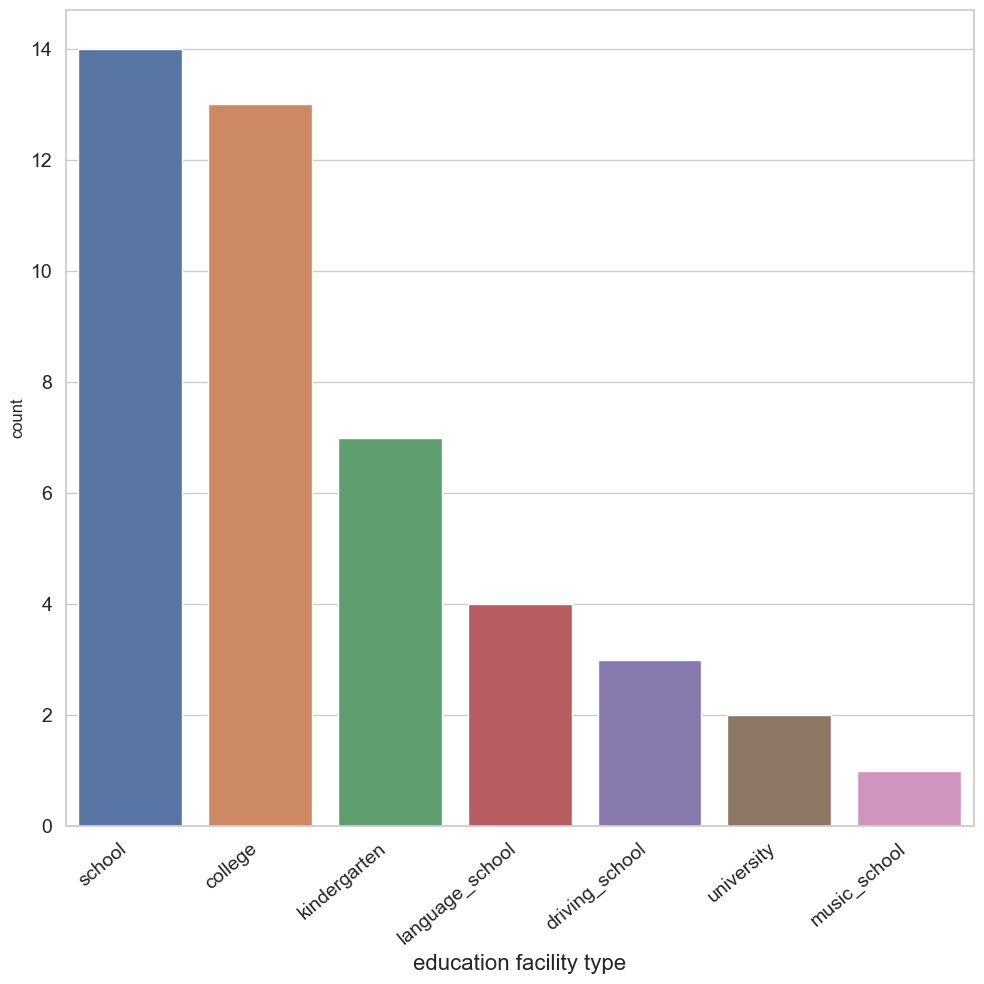

In [84]:
# create a hisogram in seaborn showing the number of schools per type
# order countplt by the number of schools per type
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.countplot(x="poi_type", data=es, order=es.poi_type.value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
# increase tick label size
ax.tick_params(labelsize=14)
# increase x and y label size
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
# change x axis label to "education facility type"
ax.set_xlabel("education facility type", fontsize=16)
plt.tight_layout()
plt.show()


## Make plot of facilities in florianopolis 

Text(0.5, 1.0, 'Florianópolis, Brazil. Education facilities')

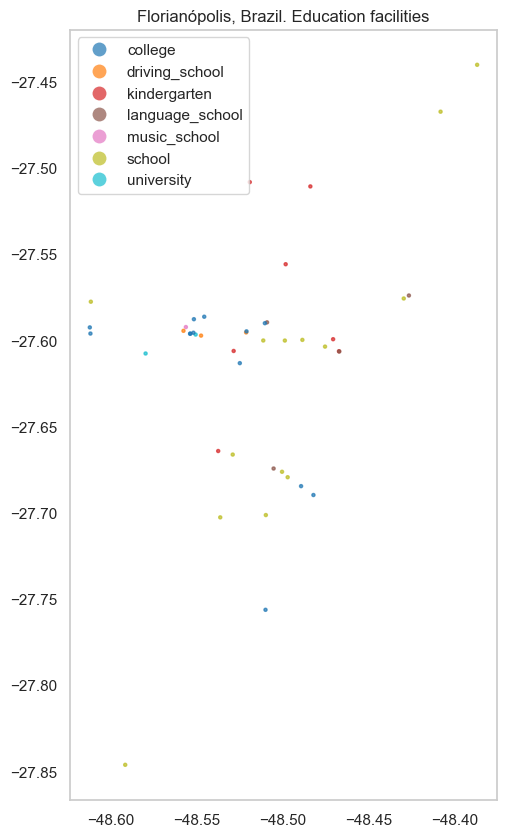

In [85]:
es.plot('poi_type', markersize = 5, alpha = 0.7, legend=True)
# mack background white with grid
plt.grid(color='white', linestyle='-', linewidth=1)
plt.title(ciudad + ". Education facilities")


## Evaluate accessibility

Here's where we can specify the type of facilities

In [86]:
# create object called schools with poi_type of school, kindergarten, language school, toy library and library
schools = es[es['poi_type'].isin(['school', 'kindergarten', 'language_school', 'library'])]

In [87]:
schools.head()

,type,id,lat,lon,tags,geometry,poi_type
0,node,1404551652,-27.679288,-48.497114,"{'amenity': 'school', 'name': 'Escola Engenho'...",POINT (-48.49711 -27.67929),school
1,node,1429425790,-27.674237,-48.505272,"{'amenity': 'language_school', 'name': 'Extra ...",POINT (-48.50527 -27.67424),language_school
2,node,1440281872,-27.676132,-48.500381,"{'addr:housenumber': '799', 'addr:street': 'Av...",POINT (-48.50038 -27.67613),school
4,node,1454993590,-27.599978,-48.511266,"{'amenity': 'school', 'name': 'Colégio COC'}",POINT (-48.51127 -27.59998),school
6,node,1681023425,-27.575607,-48.429784,"{'amenity': 'school', 'name': 'Escola Básica A...",POINT (-48.42978 -27.57561),school


Visualize just the schools

<AxesSubplot: >

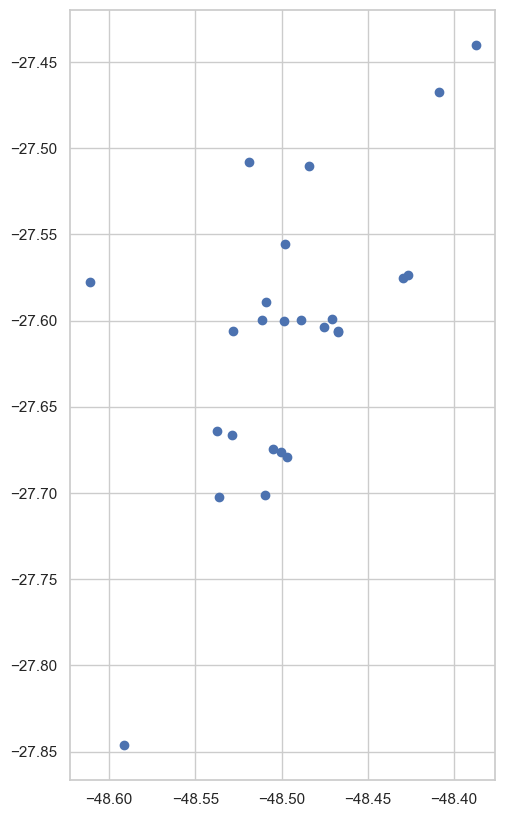

In [88]:
schools.plot()

With the location of all the schools completed, let's figure out the distance from the centroid of each hexagon in our maps created above to the eduational facilities

In [89]:
hex_flor['lat'] = hex_flor.geometry.centroid.y
hex_flor['lon'] = hex_flor.geometry.centroid.x

The nn_search function within the urbanpy library can do nearest neighbor calcualtions

In [90]:
dist_up, ind_up = up.utils.nn_search(
    tree_features=schools[['lat', 'lon']].values, # These are the schools
    query_features=hex_flor[['lat', 'lon']].values, # Values are the centroids of each hexagon
    metric='haversine'
)

Add in a new variable which will indicate the index of the closest school for that particular hexagon

In [91]:
hex_flor['closest_school'] = ind_up
hex_flor.head()

,hex,geometry,population_2020,lat,lon,closest_school
0,88a91b5747fffff,"POLYGON ((-48.51725 -27.75584, -48.51307 -27.7...",13.858327,-27.751448,-48.518116,24
1,88a91b4097fffff,"POLYGON ((-48.46816 -27.57638, -48.46398 -27.5...",NaN,-27.571976,-48.469028,14
2,88a91b4451fffff,"POLYGON ((-48.57812 -27.56660, -48.57394 -27.5...",NaN,-27.562195,-48.578989,8
3,88a91b42b1fffff,"POLYGON ((-48.47286 -27.62394, -48.46868 -27.6...",29.624559,-27.619539,-48.473727,17
4,88a91b5759fffff,"POLYGON ((-48.54492 -27.75845, -48.54074 -27.7...",83.792873,-27.754051,-48.545789,10


## Starting up OSM server

In [92]:
# Server config
OSRM_COUNTRY = "sul" # subregion name
OSRM_CONTINENT = "south-america_brazil" # combination of continent_country
OSRM_PROFILE =  "foot" # other options are 'car' or 'bicycle'

# Start server
up.routing.start_osrm_server(OSRM_COUNTRY, OSRM_CONTINENT, OSRM_PROFILE)
# Wait for the OSRM server to be running and ready to use (See screenshot below)
# This could take around 5 to 10 minutes the first time

time.sleep(20) # Subsequent start times should be between 5 - 20 seconds

# Calculate travel times and distances between 2 points
# Distance is measured in meters and duration, in seconds
distance, duration = up.routing.osrm_route(origin=point1, destination=point2)

# Stop server  
up.routing.stop_osrm_server(OSRM_COUNTRY, OSRM_CONTINENT, OSRM_PROFILE)

[]
This is the first time you used this function.
Initializing server setup. This may take several minutes...
Using default tag: latest


Error: No such object: osrm_routing_server_south-america_brazil_sul_foot


latest: Pulling from osrm/osrm-backend
Digest: sha256:af5d4a83fb90086a43b1ae2ca22872e6768766ad5fcbb07a29ff90ec644ee409
Status: Image is up to date for osrm/osrm-backend:latest
docker.io/osrm/osrm-backend:latest


/bin/sh: line 4: wget: command not found
docker: Error response from daemon: Conflict. The container name "/osrm_extract" is already in use by container "6aae95e70200660f1c8d7a5d3f609caeba7cbe42ef3a7257361f9bd152e1c2da". You have to remove (or rename) that container to be able to reuse that name.
See 'docker run --help'.
docker: Error response from daemon: Conflict. The container name "/osrm_partition" is already in use by container "f840be45c1c7031e971f43e6d3fbf4d6fa9aa555ac2c73a848a20f9fe3ab1c56". You have to remove (or rename) that container to be able to reuse that name.
See 'docker run --help'.


[info] Loaded edge based graph: 22380390 edges, 5296938 nodes
[info] Loading partition data took 15.3119 seconds
[info] Cells customization took 54.7974 seconds
[info] Cells statistics per level
[info] Level 1 #cells 23040 #boundary nodes 605992, sources: avg. 17, destinations: avg. 26, entries: 15951017 (127608136 bytes)
[info] Level 2 #cells 1946 #boundary nodes 87427, sources: avg. 30, destinations: avg. 44, entries: 3897564 (31180512 bytes)
[info] Level 3 #cells 120 #boundary nodes 7894, sources: avg. 44, destinations: avg. 64, entries: 495008 (3960064 bytes)
[info] Level 4 #cells 5 #boundary nodes 268, sources: avg. 35, destinations: avg. 52, entries: 15892 (127136 bytes)
[info] Unreachable nodes statistics per level
[info] MLD customization writing took 2.71061 seconds
[info] Graph writing took 4.72634 seconds
[info] RAM: peak bytes used: 1530040320
osrm_extract
osrm_customize


Error response from daemon: You cannot remove a running container f840be45c1c7031e971f43e6d3fbf4d6fa9aa555ac2c73a848a20f9fe3ab1c56. Stop the container before attempting removal or force remove
docker: Error response from daemon: Ports are not available: exposing port TCP 0.0.0.0:5000 -> 0.0.0.0:0: listen tcp 0.0.0.0:5000: bind: address already in use.
time="2023-02-09T13:02:43-08:00" level=error msg="error waiting for container: context canceled"


[info] Full bisection done in 137.123s
[info] Loaded node based graph to edge based graph mapping
[info] Loaded edge based graph for mapping partition ids: 22380390 edges, 5296938 nodes
[info] Fixed 1255834 unconnected nodes
[info] Edge-based-graph annotation:
[info]   level 1 #cells 23040 bit size 15
[info]   level 2 #cells 1947 bit size 11
[info]   level 3 #cells 121 bit size 7
[info]   level 4 #cells 5 bit size 3
[info] Renumbered data in 24.1021 seconds
[info] MultiLevelPartition constructed in 2.81767 seconds
[info] CellStorage constructed in 2.51724 seconds
[info] MLD data writing took 3.35439 seconds
[info] Cells statistics per level
[info] Level 1 #cells 23040 #boundary nodes 3995026, sources: avg. 95, destinations: avg. 139, entries: 4597385189 (36779081512 bytes)
[info] Level 2 #cells 1947 #boundary nodes 3298680, sources: avg. 956, destinations: avg. 1416, entries: 7039982540 (56319860320 bytes)
[info] Level 3 #cells 121 #boundary nodes 2933783, sources: avg. 13968, destinat

[info] Loaded edge based graph: 22380390 edges, 5296938 nodes
[info] Loading partition data took 14.1175 seconds
osrm_partition
osrm_customize


Error: No such container: osrm_extract
docker: Error response from daemon: Conflict. The container name "/osrm_routing_server_south-america_brazil_sul_foot" is already in use by container "2ce75c74142e442dd48ae9fca40443482527d419f2424e49a3e694cdd1576e07". You have to remove (or rename) that container to be able to reuse that name.
See 'docker run --help'.
